In [1]:
import tqdm
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

c:\Users\oscar\anaconda3\envs\comp4332\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_data(split_name='train', columns=['text', 'label'], folder='data'):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

train_df = load_data('train', columns=['text', 'label'], folder='data')
valid_df = load_data('valid', columns=['text', 'label'], folder='data')
test_df = load_data('test_no_label', columns=['id', 'text'], folder='data')

select [text, label] columns from the train split
Success
select [text, label] columns from the valid split
Success
select [id, text] columns from the test_no_label split
Success


In [3]:
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def lower(s):
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")
    
def tokenize(text):
    return nltk.word_tokenize(text)

def stem(tokens):
    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

def filter_stopwords(tokens):
    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def join(tokens):
    return ' '.join(tokens)

# train_df['text'] = train_df['text'].map(tokenize).map(filter_stopwords).map(join).map(lower)
# valid_df['text'] = valid_df['text'].map(tokenize).map(filter_stopwords).map(join).map(lower)

In [4]:
max_len = 256
class_num = 5
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class Train_Valid_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        text = row['text']
        inputs = self.tokenizer.encode_plus(text,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding='max_length', 
                                            truncation=True,
                                            return_attention_mask=True,
                                            return_tensors='pt')
        target = torch.zeros(class_num)
        target[row['label']-1] = 1.
        return {
            'input_ids':inputs['input_ids'].flatten(),
            'attention_mask':inputs['attention_mask'].flatten(),
            'token_type_ids':inputs['token_type_ids'].flatten(),
            'labels': target
        }

    def __len__(self):
        return len(self.dataframe)

train_dataset = Train_Valid_Dataset(dataframe=train_df, tokenizer=tokenizer, max_len=max_len)
valid_dataset = Train_Valid_Dataset(dataframe=valid_df, tokenizer=tokenizer, max_len=max_len)

In [5]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class SAM(nn.Module):
    def __init__(self, hidden_size, dropout_rnn, class_num):
        super(SAM, self).__init__()
        self.class_num = class_num
        self.pretrained_model = BertModel.from_pretrained("bert-base-uncased", return_dict=True)
        emb_size = self.pretrained_model.config.to_dict()['hidden_size']
        self.lstm = nn.LSTM(input_size=emb_size, 
                        hidden_size=hidden_size, 
                        num_layers=2,
                        batch_first=True,
                        dropout=dropout_rnn,
                        bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, self.class_num)
        self.loss_fnc = nn.CrossEntropyLoss()

    def forward(self, samples):
        with torch.no_grad():
            output = self.pretrained_model(samples['input_ids'].to(device, dtype=torch.long),
                                        samples['attention_mask'].to(device, dtype=torch.long),
                                        samples['token_type_ids'].to(device, dtype=torch.long),)
        _, (HiddenStates, CellStates) = self.lstm(output['last_hidden_state'])
        logits = self.linear(torch.cat((HiddenStates[0], HiddenStates[1]), dim = 1))
        loss = self.loss_fnc(logits.view(-1,self.class_num), samples['labels'].view(-1,self.class_num).to(device, dtype=torch.float))
        return {'logits':logits, 'loss':loss}
    
    def predict(self, encoded_text):
        with torch.no_grad():
            output = self.pretrained_model(encoded_text['input_ids'],
                                      encoded_text['attention_mask'],
                                      encoded_text['token_type_ids'],)
            _, (HiddenStates, CellStates) = self.lstm(output['last_hidden_state'])
            logits = self.linear2(torch.cat((HiddenStates[0], HiddenStates[1]), dim = 1))
            probi = torch.sigmoid(logits).cpu().detach().numpy().tolist()
            predict_dic = {1:probi[0],2:probi[1],3:probi[2],4:probi[3],5:probi[4]}
            return predict_dic

In [7]:
def train(num_epoch, batch_size, train_loader, valid_loader, model, optimizer, scheduler):
    history = {'train':{'loss':[], 'accuracy':[]}, 'valid':{'accuracy':[]}}
    for epoch in range(num_epoch):
        print(f'epoch{epoch}')
        model.train()
        count = 0
        running_loss = 0
        train_accuracy = 0
        train_bar = tqdm.tqdm(train_loader)
        for i, samples in enumerate(train_bar):
            optimizer.zero_grad()
            output = model(samples)
            logits = output['logits']
            loss = output['loss']
            loss.backward()
            optimizer.step()
            
            count += samples['labels'].size(0)
            running_loss = loss.item() * batch_size
            
            train_accuracy += accuracy_score(samples['labels'].argmax(-1).tolist(), logits.argmax(-1).tolist(), normalize=False)
            train_bar.set_postfix({'train_loss': running_loss / len(train_loader), 'train_accuracy': train_accuracy/count})
        
        scheduler.step()
        history['train']['loss'].append(running_loss / len(train_loader))
        history['train']['accuracy'].append(train_accuracy/count)
        model.eval()
        pred = []
        true = []
        count = 0
        valid_accuracy = 0
        valid_bar = tqdm.tqdm(valid_loader)
        for i, samples in enumerate(valid_bar):
            with torch.no_grad():
                output = model(samples)
                logits = output['logits']

            pred += logits.argmax(-1).tolist()
            true += samples['labels'].argmax(-1).tolist()
            count += samples['labels'].size(0)
            valid_accuracy += accuracy_score(samples['labels'].argmax(-1).tolist(), logits.argmax(-1).tolist(), normalize=False)
            valid_bar.set_postfix({'valid_accuracy': valid_accuracy/count})

        history['valid']['accuracy'].append(valid_accuracy/count)
        classification_report_val = classification_report(true, pred)
        confusion_matrix_val = confusion_matrix(true, pred)

        print('classification_report_val')
        print(classification_report_val)
        print("\n")
        print('confusion_matrix_val')
        print(confusion_matrix_val)

        state_dict = model.state_dict()
        save_obj = {
          "model": state_dict,
          "classification_report_val": classification_report_val,
          "confusion_matrix_val": confusion_matrix_val,
        }

        save_to = f"models/sam_epoch_{epoch}.pth"
        torch.save(save_obj, save_to)
        print(f'checkpoint saved to:{save_to}')
    return history

In [20]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
model = SAM(128, 0.0, class_num=class_num)
model.to(device)
num_epoch = 6
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=7)
history_128 = train(num_epoch=num_epoch, 
      batch_size=batch_size, 
      train_loader=train_loader, 
      valid_loader=valid_loader, 
      model=model, 
      optimizer=optimizer,
      scheduler = scheduler
)

epoch0


100%|██████████| 16/16 [00:09<00:00,  1.74it/s, valid_accuracy=0.52] 


classification_report_val
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       295
           1       0.41      0.12      0.19       198
           2       0.47      0.50      0.48       508
           3       0.45      0.42      0.44       523
           4       0.58      0.74      0.65       476

    accuracy                           0.52      2000
   macro avg       0.51      0.49      0.48      2000
weighted avg       0.51      0.52      0.50      2000



confusion_matrix_val
[[191  21  53  13  17]
 [ 60  24  94  15   5]
 [ 38  13 252 159  46]
 [ 11   0 106 222 184]
 [ 10   0  27  87 352]]
checkpoint saved to:models/sam_epoch_0.pth
epoch1


100%|██████████| 16/16 [00:09<00:00,  1.68it/s, valid_accuracy=0.537]


classification_report_val
              precision    recall  f1-score   support

           0       0.54      0.78      0.63       295
           1       0.38      0.18      0.25       198
           2       0.50      0.56      0.53       508
           3       0.52      0.37      0.43       523
           4       0.62      0.70      0.66       476

    accuracy                           0.54      2000
   macro avg       0.51      0.52      0.50      2000
weighted avg       0.53      0.54      0.52      2000



confusion_matrix_val
[[229  16  36   3  11]
 [ 92  36  62   5   3]
 [ 65  37 284  90  32]
 [ 21   5 144 194 159]
 [ 20   1  42  81 332]]
checkpoint saved to:models/sam_epoch_1.pth
epoch2


100%|██████████| 16/16 [00:09<00:00,  1.67it/s, valid_accuracy=0.545]


classification_report_val
              precision    recall  f1-score   support

           0       0.57      0.76      0.65       295
           1       0.45      0.17      0.24       198
           2       0.50      0.59      0.54       508
           3       0.49      0.52      0.50       523
           4       0.69      0.56      0.62       476

    accuracy                           0.55      2000
   macro avg       0.54      0.52      0.51      2000
weighted avg       0.55      0.55      0.54      2000



confusion_matrix_val
[[223  19  43   5   5]
 [ 74  33  82   9   0]
 [ 60  18 299 116  15]
 [ 18   2 135 270  98]
 [ 18   1  43 148 266]]
checkpoint saved to:models/sam_epoch_2.pth
epoch3


100%|██████████| 16/16 [00:09<00:00,  1.65it/s, valid_accuracy=0.541]


classification_report_val
              precision    recall  f1-score   support

           0       0.57      0.77      0.65       295
           1       0.40      0.16      0.23       198
           2       0.52      0.50      0.51       508
           3       0.48      0.46      0.47       523
           4       0.62      0.69      0.65       476

    accuracy                           0.54      2000
   macro avg       0.52      0.52      0.50      2000
weighted avg       0.53      0.54      0.53      2000



confusion_matrix_val
[[228  16  29  10  12]
 [ 91  31  62  11   3]
 [ 55  28 255 134  36]
 [ 15   1 115 239 153]
 [ 14   1  30 102 329]]
checkpoint saved to:models/sam_epoch_3.pth
epoch4


100%|██████████| 16/16 [00:09<00:00,  1.63it/s, valid_accuracy=0.548]


classification_report_val
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       295
           1       0.41      0.32      0.36       198
           2       0.52      0.51      0.51       508
           3       0.50      0.43      0.46       523
           4       0.61      0.72      0.66       476

    accuracy                           0.55      2000
   macro avg       0.53      0.54      0.53      2000
weighted avg       0.54      0.55      0.54      2000



confusion_matrix_val
[[208  35  34   4  14]
 [ 64  63  58   7   6]
 [ 40  52 259 120  37]
 [ 14   2 121 224 162]
 [ 12   2  29  90 343]]
checkpoint saved to:models/sam_epoch_4.pth
epoch5


100%|██████████| 16/16 [00:09<00:00,  1.68it/s, valid_accuracy=0.544]


classification_report_val
              precision    recall  f1-score   support

           0       0.65      0.68      0.67       295
           1       0.41      0.33      0.37       198
           2       0.52      0.42      0.46       508
           3       0.47      0.55      0.51       523
           4       0.62      0.68      0.65       476

    accuracy                           0.54      2000
   macro avg       0.54      0.53      0.53      2000
weighted avg       0.54      0.54      0.54      2000



confusion_matrix_val
[[202  37  33  10  13]
 [ 53  65  57  18   5]
 [ 37  50 211 173  37]
 [ 10   5  80 286 142]
 [ 10   1  22 119 324]]
checkpoint saved to:models/sam_epoch_5.pth


In [ ]:
torch.cuda.empty_cache()
num_epoch = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
model = SAM(128, 0.3, class_num=class_num)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=7)
history_128_drop = train(num_epoch=num_epoch, 
      batch_size=batch_size, 
      train_loader=train_loader, 
      valid_loader=valid_loader, 
      model=model, 
      optimizer=optimizer,
      scheduler = scheduler
)

epoch0


100%|██████████| 16/16 [00:09<00:00,  1.74it/s, valid_accuracy=0.535]


classification_report_val
              precision    recall  f1-score   support

           0       0.58      0.73      0.64       295
           1       0.68      0.08      0.14       198
           2       0.47      0.59      0.53       508
           3       0.47      0.51      0.49       523
           4       0.68      0.58      0.62       476

    accuracy                           0.54      2000
   macro avg       0.58      0.50      0.48      2000
weighted avg       0.56      0.54      0.52      2000



confusion_matrix_val
[[215   3  64   7   6]
 [ 74  15  96  10   3]
 [ 49   4 299 135  21]
 [ 17   0 137 268 101]
 [ 17   0  34 151 274]]
checkpoint saved to:models/sam_epoch_0.pth
epoch1


100%|██████████| 16/16 [00:09<00:00,  1.74it/s, valid_accuracy=0.532]


classification_report_val
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       295
           1       0.41      0.19      0.26       198
           2       0.46      0.62      0.53       508
           3       0.52      0.36      0.42       523
           4       0.58      0.75      0.66       476

    accuracy                           0.53      2000
   macro avg       0.53      0.50      0.50      2000
weighted avg       0.53      0.53      0.52      2000



confusion_matrix_val
[[167  32  77   2  17]
 [ 45  38 103   4   8]
 [ 25  22 317  98  46]
 [  5   0 150 186 182]
 [  5   0  44  71 356]]
checkpoint saved to:models/sam_epoch_1.pth
epoch2


100%|██████████| 16/16 [00:09<00:00,  1.75it/s, valid_accuracy=0.53] 


classification_report_val
              precision    recall  f1-score   support

           0       0.55      0.79      0.65       295
           1       0.45      0.19      0.26       198
           2       0.52      0.40      0.45       508
           3       0.45      0.54      0.49       523
           4       0.63      0.64      0.64       476

    accuracy                           0.53      2000
   macro avg       0.52      0.51      0.50      2000
weighted avg       0.53      0.53      0.52      2000



confusion_matrix_val
[[232  13  23  13  14]
 [ 93  37  45  18   5]
 [ 69  31 204 174  30]
 [ 15   1  97 280 130]
 [ 12   0  20 137 307]]
checkpoint saved to:models/sam_epoch_2.pth
epoch3


100%|██████████| 16/16 [00:09<00:00,  1.77it/s, valid_accuracy=0.543]


classification_report_val
              precision    recall  f1-score   support

           0       0.55      0.81      0.66       295
           1       0.46      0.17      0.24       198
           2       0.51      0.53      0.52       508
           3       0.50      0.39      0.44       523
           4       0.61      0.72      0.66       476

    accuracy                           0.54      2000
   macro avg       0.53      0.52      0.50      2000
weighted avg       0.53      0.54      0.52      2000



confusion_matrix_val
[[239  12  29   4  11]
 [ 91  33  62   7   5]
 [ 69  26 267 114  32]
 [ 19   0 130 206 168]
 [ 16   1  40  77 342]]
checkpoint saved to:models/sam_epoch_3.pth
epoch4


100%|██████████| 16/16 [00:09<00:00,  1.77it/s, valid_accuracy=0.545]


classification_report_val
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       295
           1       0.40      0.17      0.24       198
           2       0.50      0.57      0.53       508
           3       0.49      0.42      0.46       523
           4       0.60      0.73      0.66       476

    accuracy                           0.55      2000
   macro avg       0.53      0.51      0.51      2000
weighted avg       0.53      0.55      0.53      2000



confusion_matrix_val
[[194  27  47   8  19]
 [ 59  34  86  11   8]
 [ 30  24 291 122  41]
 [  9   0 126 222 166]
 [  6   0  32  89 349]]
checkpoint saved to:models/sam_epoch_4.pth
epoch5


100%|██████████| 16/16 [00:09<00:00,  1.77it/s, valid_accuracy=0.543]


classification_report_val
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       295
           1       0.38      0.22      0.28       198
           2       0.50      0.53      0.52       508
           3       0.48      0.47      0.47       523
           4       0.62      0.69      0.66       476

    accuracy                           0.54      2000
   macro avg       0.53      0.52      0.52      2000
weighted avg       0.53      0.54      0.54      2000



confusion_matrix_val
[[197  36  38   8  16]
 [ 62  44  76  10   6]
 [ 31  35 270 141  31]
 [  9   1 121 245 147]
 [  5   0  31 110 330]]
checkpoint saved to:models/sam_epoch_5.pth


In [22]:
torch.cuda.empty_cache()
num_epoch = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
model = SAM(256, 0.3, class_num=class_num)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=7)
history_256_drop = train(num_epoch=num_epoch, 
      batch_size=batch_size, 
      train_loader=train_loader, 
      valid_loader=valid_loader, 
      model=model, 
      optimizer=optimizer,
      scheduler = scheduler
)

epoch0


100%|██████████| 16/16 [00:09<00:00,  1.70it/s, valid_accuracy=0.531]


classification_report_val
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       295
           1       0.48      0.18      0.26       198
           2       0.50      0.54      0.52       508
           3       0.50      0.34      0.40       523
           4       0.57      0.75      0.65       476

    accuracy                           0.53      2000
   macro avg       0.52      0.51      0.49      2000
weighted avg       0.52      0.53      0.51      2000



confusion_matrix_val
[[221  12  41   3  18]
 [ 78  36  70   7   7]
 [ 62  26 273 102  45]
 [ 22   1 125 177 198]
 [ 19   0  36  66 355]]
checkpoint saved to:models/sam_epoch_0.pth
epoch1


100%|██████████| 16/16 [00:09<00:00,  1.61it/s, valid_accuracy=0.531]


classification_report_val
              precision    recall  f1-score   support

           0       0.60      0.70      0.64       295
           1       0.37      0.29      0.32       198
           2       0.50      0.50      0.50       508
           3       0.47      0.47      0.47       523
           4       0.63      0.63      0.63       476

    accuracy                           0.53      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.53      0.53      0.53      2000



confusion_matrix_val
[[206  41  30   5  13]
 [ 60  57  68   8   5]
 [ 51  47 256 129  25]
 [ 14   7 122 246 134]
 [ 13   1  32 132 298]]
checkpoint saved to:models/sam_epoch_1.pth
epoch2


100%|██████████| 16/16 [00:09<00:00,  1.60it/s, valid_accuracy=0.524]


classification_report_val
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       295
           1       0.40      0.12      0.18       198
           2       0.54      0.40      0.46       508
           3       0.47      0.40      0.43       523
           4       0.59      0.76      0.66       476

    accuracy                           0.52      2000
   macro avg       0.50      0.51      0.47      2000
weighted avg       0.51      0.52      0.50      2000



confusion_matrix_val
[[250   4  19   7  15]
 [115  23  44  12   4]
 [ 90  27 203 144  44]
 [ 24   3  95 210 191]
 [ 18   1  18  77 362]]
checkpoint saved to:models/sam_epoch_2.pth
epoch3


100%|██████████| 16/16 [00:09<00:00,  1.66it/s, valid_accuracy=0.553]


classification_report_val
              precision    recall  f1-score   support

           0       0.65      0.66      0.66       295
           1       0.43      0.23      0.30       198
           2       0.50      0.64      0.56       508
           3       0.52      0.39      0.45       523
           4       0.61      0.71      0.66       476

    accuracy                           0.55      2000
   macro avg       0.54      0.53      0.52      2000
weighted avg       0.55      0.55      0.54      2000



confusion_matrix_val
[[195  28  49   6  17]
 [ 64  45  77   8   4]
 [ 26  30 324  89  39]
 [  8   1 152 203 159]
 [  6   0  48  82 340]]
checkpoint saved to:models/sam_epoch_3.pth
epoch4


100%|██████████| 16/16 [00:10<00:00,  1.60it/s, valid_accuracy=0.54] 


classification_report_val
              precision    recall  f1-score   support

           0       0.61      0.75      0.67       295
           1       0.43      0.12      0.18       198
           2       0.51      0.49      0.50       508
           3       0.48      0.46      0.47       523
           4       0.59      0.74      0.66       476

    accuracy                           0.54      2000
   macro avg       0.52      0.51      0.49      2000
weighted avg       0.53      0.54      0.52      2000



confusion_matrix_val
[[220  10  40  10  15]
 [ 78  23  80  11   6]
 [ 47  21 247 147  46]
 [ 10   0 101 240 172]
 [  8   0  20  97 351]]
checkpoint saved to:models/sam_epoch_4.pth
epoch5


100%|██████████| 16/16 [00:10<00:00,  1.59it/s, valid_accuracy=0.541]


classification_report_val
              precision    recall  f1-score   support

           0       0.56      0.80      0.66       295
           1       0.37      0.21      0.27       198
           2       0.53      0.40      0.46       508
           3       0.48      0.50      0.49       523
           4       0.63      0.71      0.67       476

    accuracy                           0.54      2000
   macro avg       0.51      0.52      0.51      2000
weighted avg       0.53      0.54      0.53      2000



confusion_matrix_val
[[237  17  22   8  11]
 [ 93  41  46  14   4]
 [ 63  47 204 158  36]
 [ 15   5  94 261 148]
 [ 14   0  22 101 339]]
checkpoint saved to:models/sam_epoch_5.pth


In [12]:
history_128_drop=history_512_drop

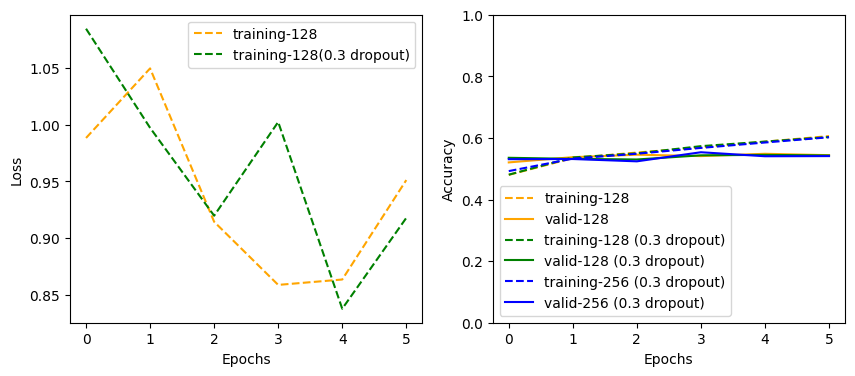

In [23]:
import matplotlib.pyplot as plt
''' Plot loss-iteration '''
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_128['train']['loss'], label="training-128", color="orange", linestyle="dashed")
plt.plot(history_128_drop['train']['loss'], label="training-128(0.3 dropout)", color="green", linestyle="dashed")
# plt.plot(loss_history.history["val_loss"], label="in-valid", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

''' Plot accuracy-iteration '''
plt.subplot(1,2,2)
plt.plot(history_128['train']['accuracy'], label="training-128", color="orange", linestyle="dashed")
plt.plot(history_128['valid']['accuracy'], label="valid-128", color="orange")
plt.plot(history_128_drop['train']['accuracy'], label="training-128 (0.3 dropout)", color="green", linestyle="dashed")
plt.plot(history_128_drop['valid']['accuracy'], label="valid-128 (0.3 dropout)", color="green")
plt.plot(history_256_drop['train']['accuracy'], label="training-256 (0.3 dropout)", color="blue", linestyle="dashed")
plt.plot(history_256_drop['valid']['accuracy'], label="valid-256 (0.3 dropout)", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim((0.0, 1.0))
plt.legend()

# ''' Plot accuracy-iteration '''
# plt.subplot(1,3,3)
# plt.plot(mlp_history.history["lr"], label="training", color="blue")
# plt.xlabel("Iteration")
# plt.ylabel("LR")
# plt.legend()
# plt.show()

In [27]:
torch.cuda.empty_cache()
num_epoch = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
model = SAM(128, 0.0, class_num=class_num)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)
train(num_epoch=num_epoch, 
      batch_size=batch_size, 
      train_loader=train_loader, 
      valid_loader=valid_loader, 
      model=model, 
      optimizer=optimizer,
      scheduler = scheduler
)

epoch0


100%|██████████| 16/16 [00:09<00:00,  1.69it/s, valid_accuracy=0.53] 


classification_report_val
              precision    recall  f1-score   support

           0       0.53      0.82      0.64       295
           1       0.41      0.15      0.22       198
           2       0.47      0.64      0.54       508
           3       0.51      0.38      0.44       523
           4       0.68      0.55      0.61       476

    accuracy                           0.53      2000
   macro avg       0.52      0.51      0.49      2000
weighted avg       0.53      0.53      0.51      2000



confusion_matrix_val
[[242  12  34   2   5]
 [ 87  29  78   3   1]
 [ 71  28 326  68  15]
 [ 26   1 196 199 101]
 [ 30   1  63 118 264]]
checkpoint saved to:models/sam_epoch_0.pth


{'train': {'loss': [1.0749626430213874], 'accuracy': [0.48594444444444446]},
 'valid': {'accuracy': [0.53]}}

In [28]:
torch.cuda.empty_cache()
num_epoch = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
model = SAM(256, 0.0, class_num=class_num)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)
train(num_epoch=num_epoch, 
      batch_size=batch_size, 
      train_loader=train_loader, 
      valid_loader=valid_loader, 
      model=model, 
      optimizer=optimizer,
      scheduler = scheduler
)

epoch0


100%|██████████| 16/16 [00:09<00:00,  1.70it/s, valid_accuracy=0.527]


classification_report_val
              precision    recall  f1-score   support

           0       0.54      0.78      0.64       295
           1       0.44      0.18      0.26       198
           2       0.49      0.56      0.52       508
           3       0.51      0.27      0.35       523
           4       0.57      0.77      0.66       476

    accuracy                           0.53      2000
   macro avg       0.51      0.51      0.48      2000
weighted avg       0.52      0.53      0.50      2000



confusion_matrix_val
[[229  14  41   0  11]
 [ 76  36  78   3   5]
 [ 67  30 284  83  44]
 [ 26   2 143 139 213]
 [ 27   0  38  45 366]]
checkpoint saved to:models/sam_epoch_0.pth


{'train': {'loss': [1.033137652890902], 'accuracy': [0.4900555555555556]},
 'valid': {'accuracy': [0.527]}}

In [29]:
torch.cuda.empty_cache()
num_epoch = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
model = SAM(512, 0.0, class_num=class_num)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)
train(num_epoch=num_epoch, 
      batch_size=batch_size, 
      train_loader=train_loader, 
      valid_loader=valid_loader, 
      model=model, 
      optimizer=optimizer,
      scheduler = scheduler
)

epoch0


100%|██████████| 16/16 [00:09<00:00,  1.62it/s, valid_accuracy=0.518]


classification_report_val
              precision    recall  f1-score   support

           0       0.53      0.81      0.64       295
           1       0.35      0.17      0.23       198
           2       0.48      0.42      0.45       508
           3       0.46      0.39      0.42       523
           4       0.60      0.73      0.66       476

    accuracy                           0.52      2000
   macro avg       0.49      0.50      0.48      2000
weighted avg       0.50      0.52      0.50      2000



confusion_matrix_val
[[239  13  24   9  10]
 [ 92  34  61   8   3]
 [ 77  46 213 137  35]
 [ 20   5 116 202 180]
 [ 20   0  28  79 349]]
checkpoint saved to:models/sam_epoch_0.pth


{'train': {'loss': [1.1284899339608268], 'accuracy': [0.4893888888888889]},
 'valid': {'accuracy': [0.5185]}}